# *BEATS CT reconstruction pipeline*
[TomoPy](https://tomopy.readthedocs.io/en/latest/) reconstruction pipeline for the [BEATS beamline](https://beats-sesame.eu/) of [SESAME](https://www.sesame.org.jo/)

Created on:  23.05.2021 <br />
Last update: 25.07.2023 <br />

- By: [Gianluca Iori](https://github.com/gianthk), 2023
- Code license: MIT
- Narrative license: CC-BY-NC-SA

## Load experiment data

In [1]:
sample_name = "fiber_wet_below_kink_HR-20230726T171211"
work_dir = "/mnt/PETRA/SED/BEATS/IH/"+sample_name
h5file = work_dir+"/"+sample_name+".h5"
recon_dir = "/home/beats/Data/AlHandawi/"+sample_name+"/recon_phase/"
cor_dir = "/home/beats/Data/AlHandawi/"+sample_name+"/cor/"

Read the complete dataset

In [373]:
projs, flats, darks, theta = dxchange.read_aps_32id(h5file, exchange_rank=0, sino=(10, 2161, 1))

INFO:dxchange.reader:Data successfully imported: /mnt/PETRA/SED/BEATS/IH/fiber_dry_below_kink_newfiber-attempt3_HR-20230727T120402/fiber_dry_below_kink_newfiber-attempt3_HR-20230727T120402.h5
INFO:dxchange.reader:Data successfully imported: /mnt/PETRA/SED/BEATS/IH/fiber_dry_below_kink_newfiber-attempt3_HR-20230727T120402/fiber_dry_below_kink_newfiber-attempt3_HR-20230727T120402.h5
INFO:dxchange.reader:Data successfully imported: /mnt/PETRA/SED/BEATS/IH/fiber_dry_below_kink_newfiber-attempt3_HR-20230727T120402/fiber_dry_below_kink_newfiber-attempt3_HR-20230727T120402.h5
INFO:dxchange.reader:Data successfully imported: /mnt/PETRA/SED/BEATS/IH/fiber_dry_below_kink_newfiber-attempt3_HR-20230727T120402/fiber_dry_below_kink_newfiber-attempt3_HR-20230727T120402.h5


Read command for dynamic scans

In [ ]:
projs, flats, darks, theta = dxchange.read_aps_32id(h5file, exchange_rank=0, sino=(10, 400, 1), proj=(9601, 10001, 1))

Read portion of static scan

In [5]:
projs, flats, darks, theta = dxchange.read_aps_32id(h5file, exchange_rank=0, sino=(600, 1200, 1))

INFO:dxchange.reader:Data successfully imported: /mnt/PETRA/SED/BEATS/IH/fiber_wet_below_kink_HR-20230726T171211/fiber_wet_below_kink_HR-20230726T171211.h5
INFO:dxchange.reader:Data successfully imported: /mnt/PETRA/SED/BEATS/IH/fiber_wet_below_kink_HR-20230726T171211/fiber_wet_below_kink_HR-20230726T171211.h5
INFO:dxchange.reader:Data successfully imported: /mnt/PETRA/SED/BEATS/IH/fiber_wet_below_kink_HR-20230726T171211/fiber_wet_below_kink_HR-20230726T171211.h5
INFO:dxchange.reader:Data successfully imported: /mnt/PETRA/SED/BEATS/IH/fiber_wet_below_kink_HR-20230726T171211/fiber_wet_below_kink_HR-20230726T171211.h5


In [6]:
print(projs[:, :, :].shape[:])
print(darks[:, :, :].shape[:])
print(theta.shape[:])
print(projs.dtype)

(1001, 600, 1376)
(41, 600, 1376)
(1001,)
uint16


**For Dynamic:** Select angle array corresponding to scan

In [201]:
theta=theta[9601:10001]
# theta=theta[9601:10001]

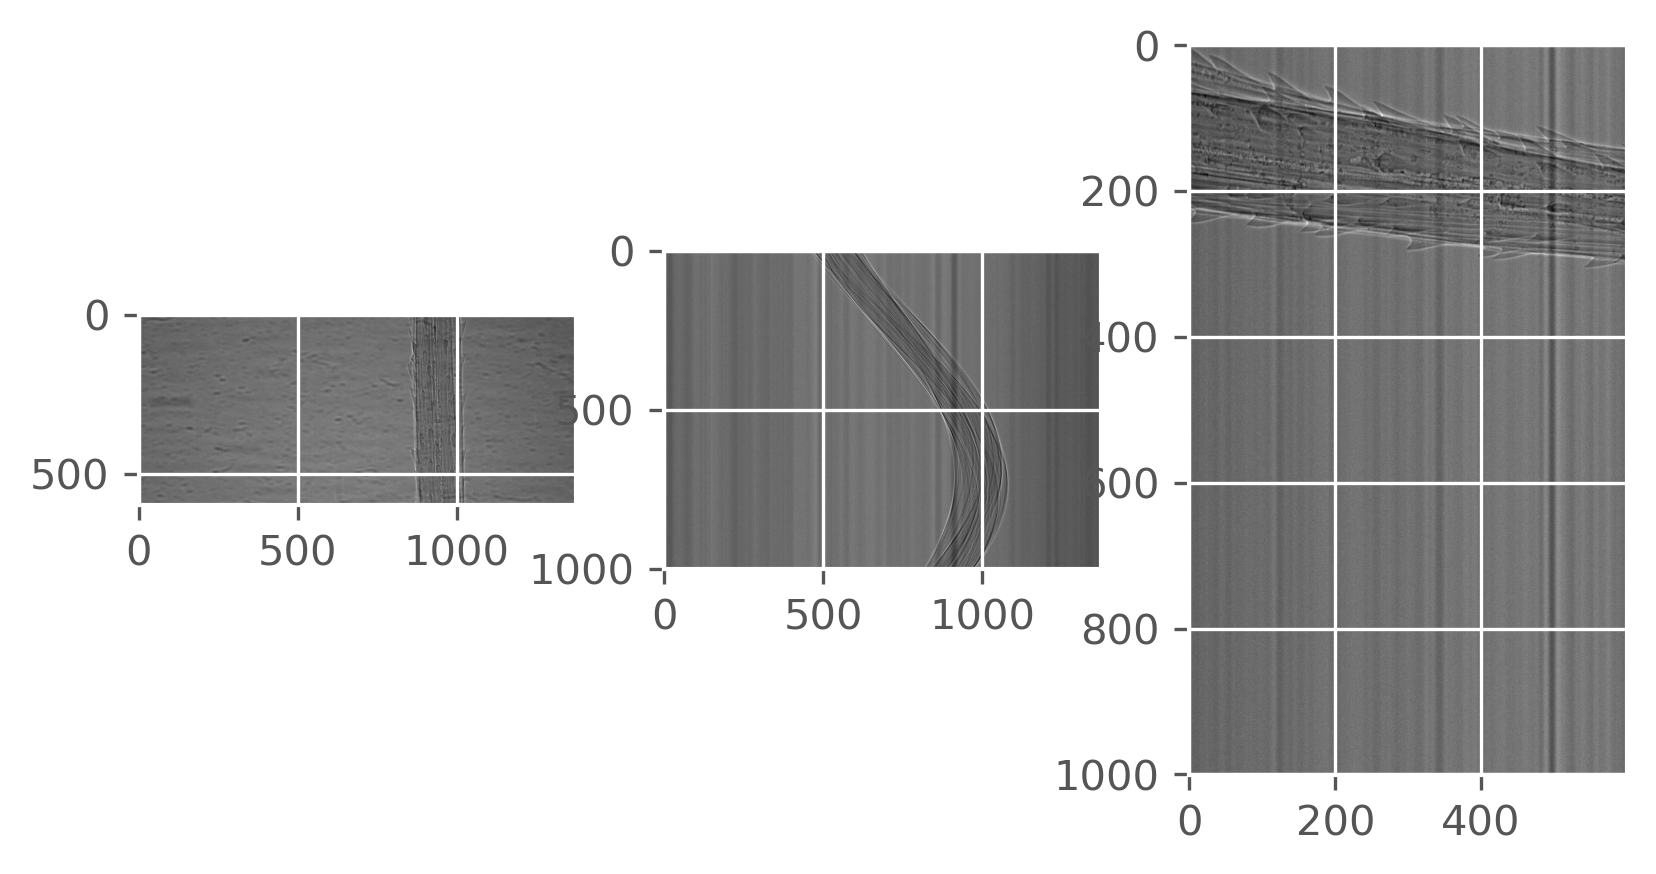

In [7]:
ru.plot_midplanes(projs)

## Flat field correction

In [8]:
# projs = tomopy.normalize(projs, flats, darks, ncore=ncore, averaging='mean') # averaging='mean'
projs = tomopy.normalize(projs, flats, darks, ncore=ncore, averaging='median') # averaging='mean'

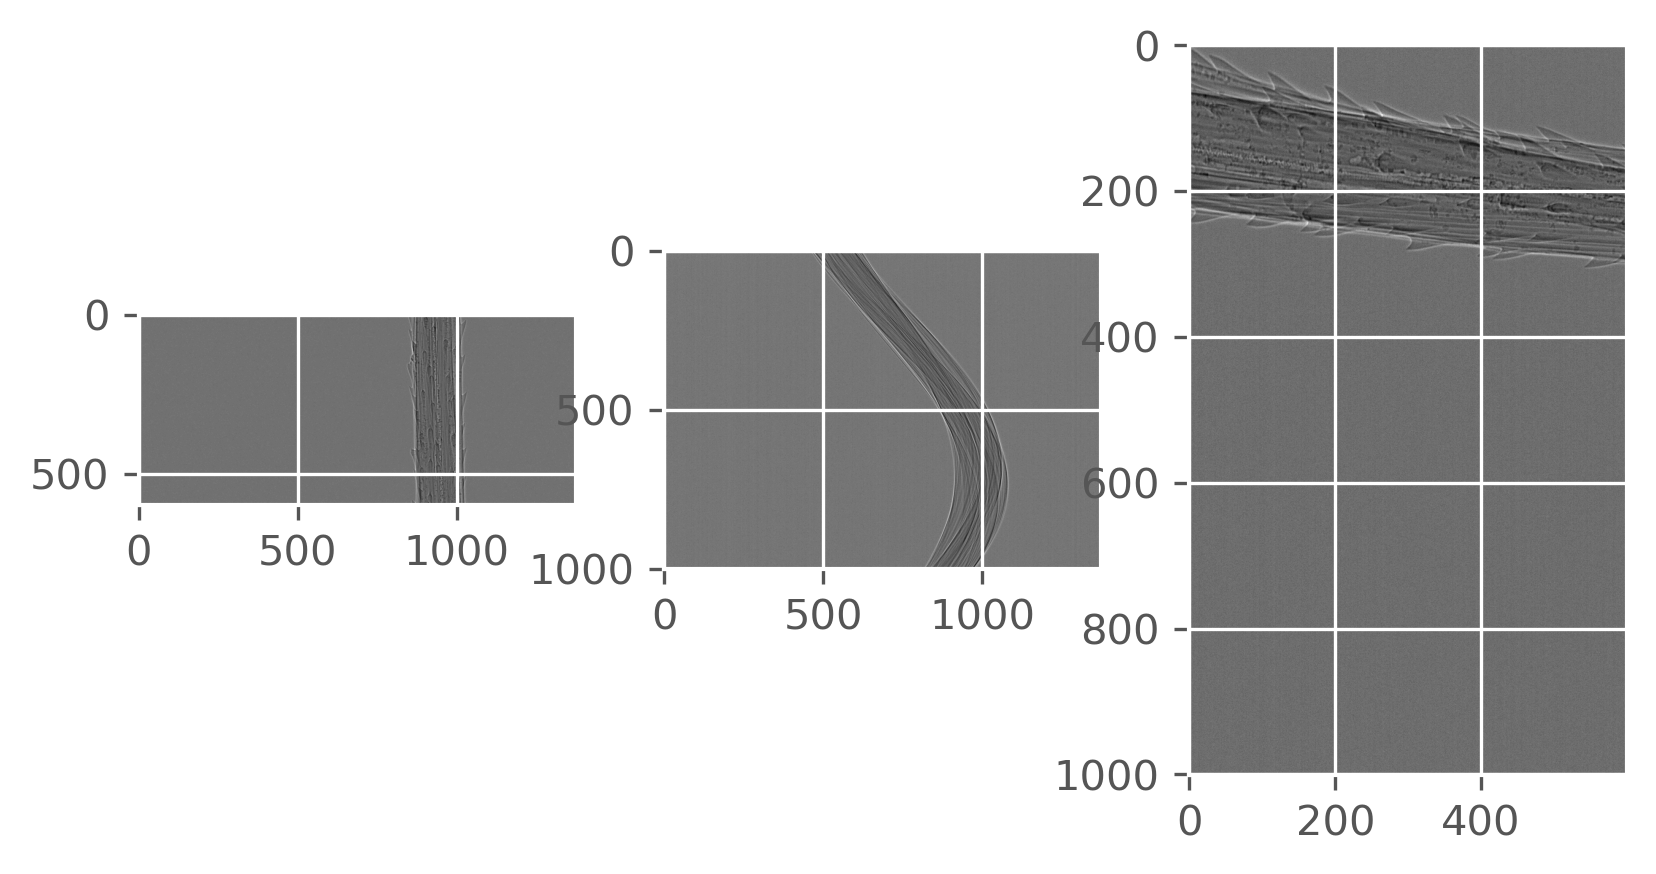

In [9]:
ru.plot_midplanes(projs)

## Phase retrieval

In [322]:
# import ipywidgets as widgets

In [323]:
# widgets.IntSlider()

In [324]:
# widgets.Checkbox(
#     value=False,
#     description='Check me',
#     disabled=False,
#     indent=False
# )

In [11]:
delta_beta = 250
alpha=1./(4*3.141592**2 * delta_beta)
print("alpha: ", alpha)

alpha:  0.00010132122580089835


In [21]:
projs_phase = tomopy.retrieve_phase(projs[:, :, :],
                                    pixel_size=1e-4*(6.5/10),
                                    dist=2,
                                    energy=10,
                                    alpha=0.0002,
                                    ncore=ncore,
                                    nchunk=None,
                                    pad=True
                                   )
# alpha=0.0000001,
# pad=True,

In [22]:
print(projs_phase[:, :, :].shape[:])

(1001, 600, 1376)


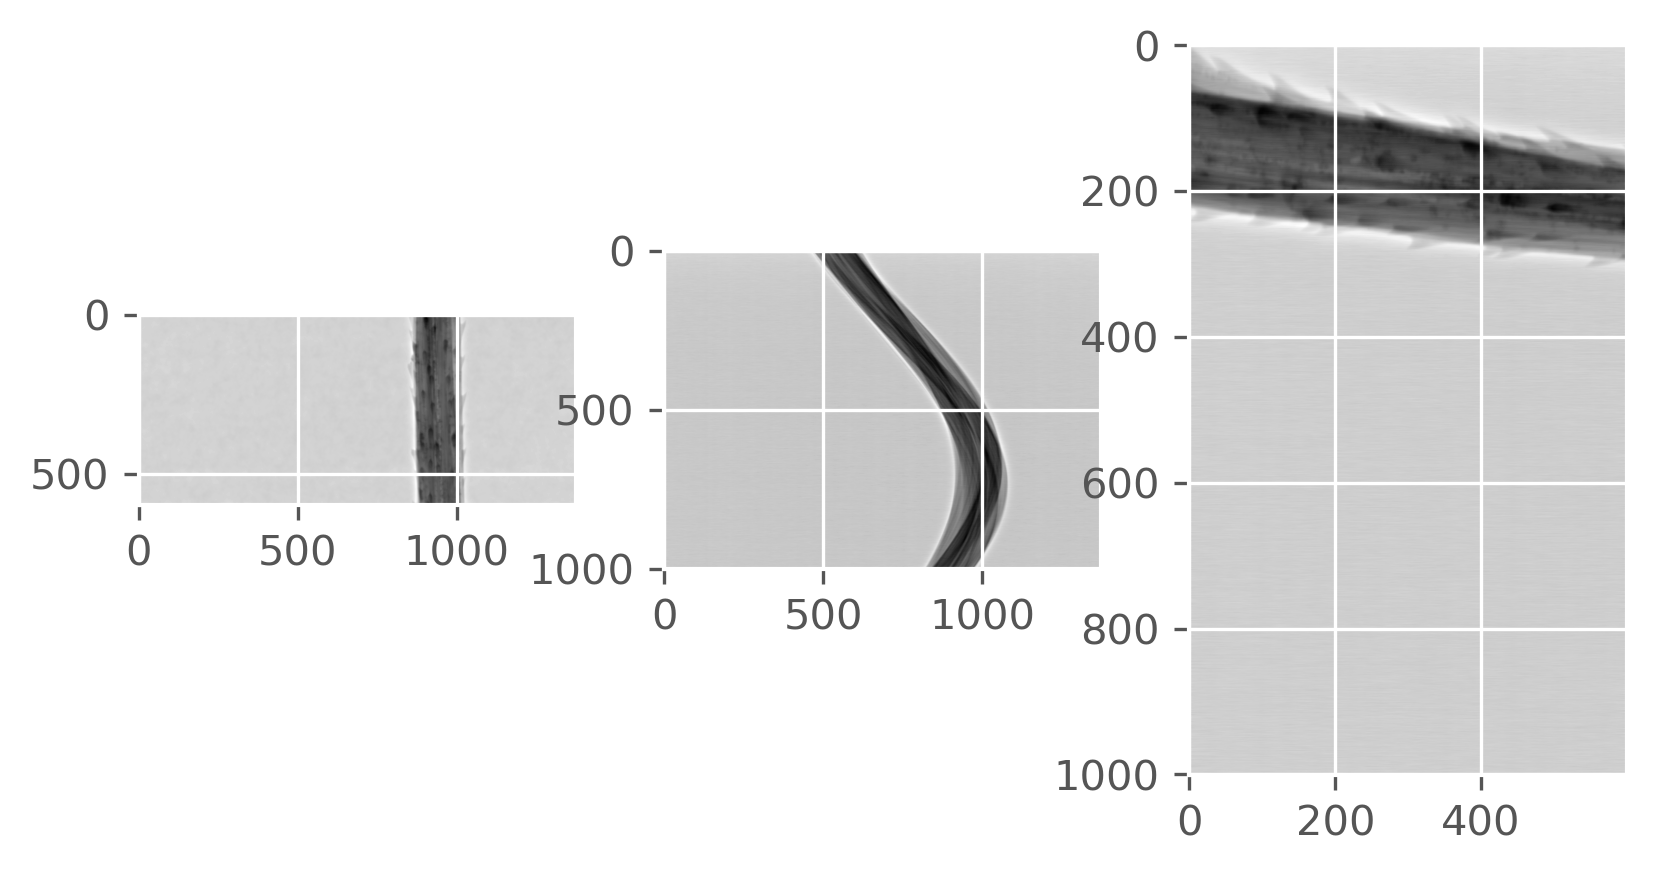

In [13]:
ru.plot_midplanes(projs_phase)

In [15]:
import napari

In [19]:
viewer = napari.view_image(projs)

In [126]:
COR = projs_180.shape[2]/2

In [11]:
# projs = tomopy.prep.stripe.remove_dead_stripe(projs, ncore=ncore)
# projs = tomopy.prep.stripe.remove_large_stripe(projs, ncore=ncore)
projs = tomopy.prep.stripe.remove_stripe_based_fitting(projs, ncore=ncore)

## Log transform
Calculate $ -log(projs) $ to linearize transmission tomography data.

In [295]:
projs = tomopy.minus_log(projs, ncore=ncore)

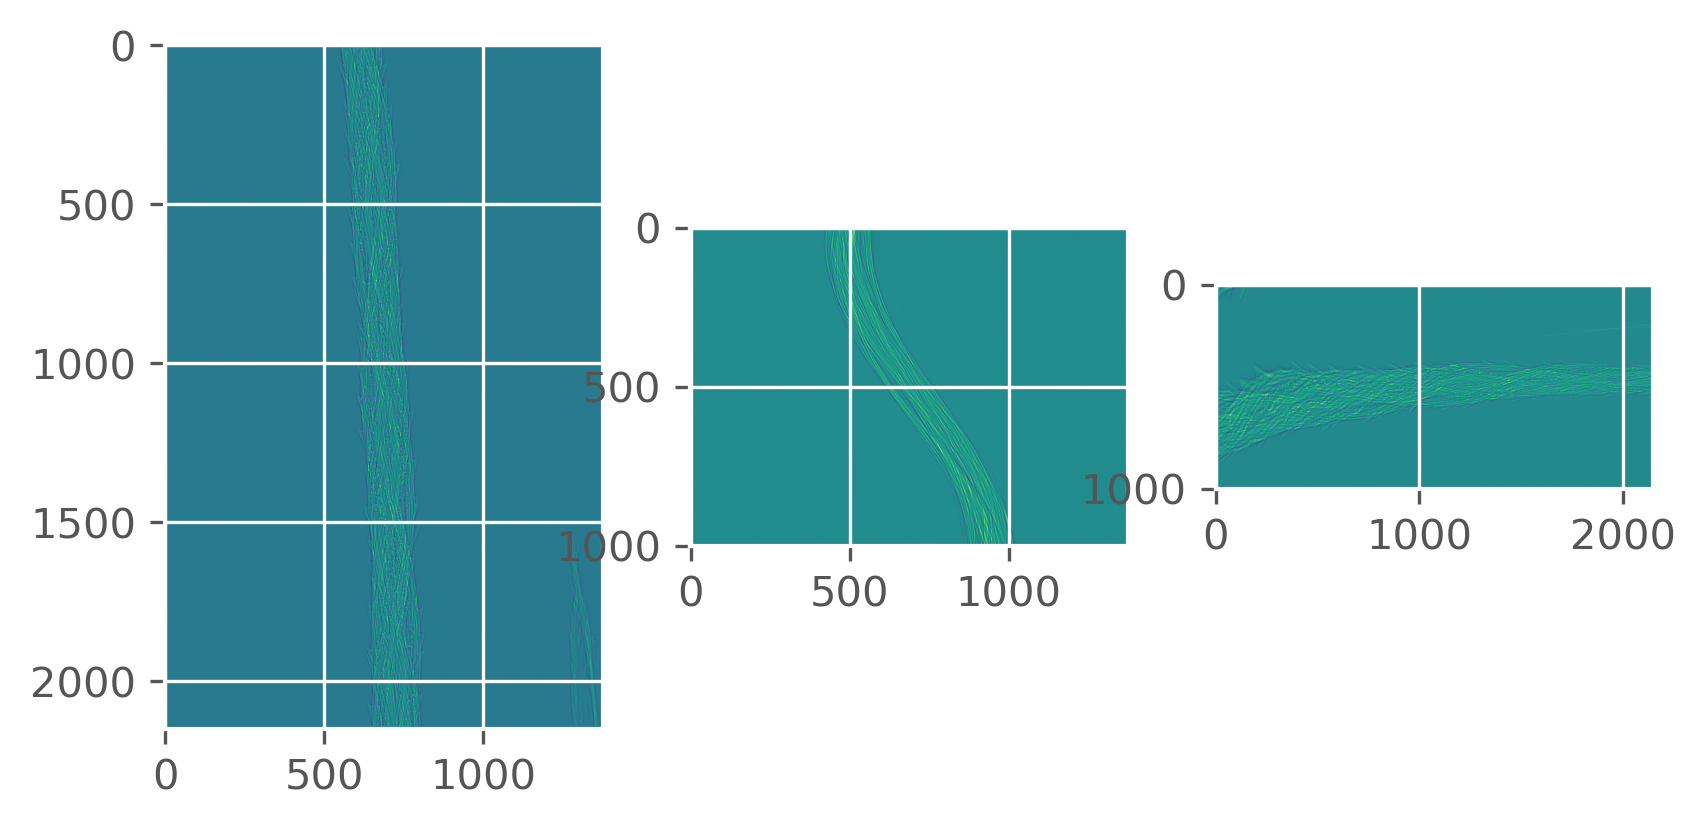

In [296]:
ru.plot_midplanes(projs)

## Center Of Rotation (COR)
### Automatic detect COR

In [ ]:
COR = tomopy.find_center_vo(projs[1000:,:,:], ncore=ncore)
print(COR)

In [141]:
pad_size = 0

In [20]:
COR = 718.5

### Save images reconstructed with COR range

In [225]:
cor_range = [700, 728, 0.5]
# cor_range = [796, 806, 0.5]

In [226]:
tomopy.write_center(projs, theta, cor_dir, cor_range)

INFO:tomopy.recon.algorithm:Reconstructing 56 slice groups with 36 master threads...


View them in Fiji

In [64]:
os.system(Fiji_exe_stack + cor_dir+'{:04.2f}'.format(COR[0])+'.tiff &')

0

## Reconstruction

### Data padding

In [51]:
pad_size = 300

In [52]:
projs_pad = tomopy.pad(projs_phase,
                       axis=2,
                       npad=pad_size,
                       mode='constant',
                       ncore=ncore)

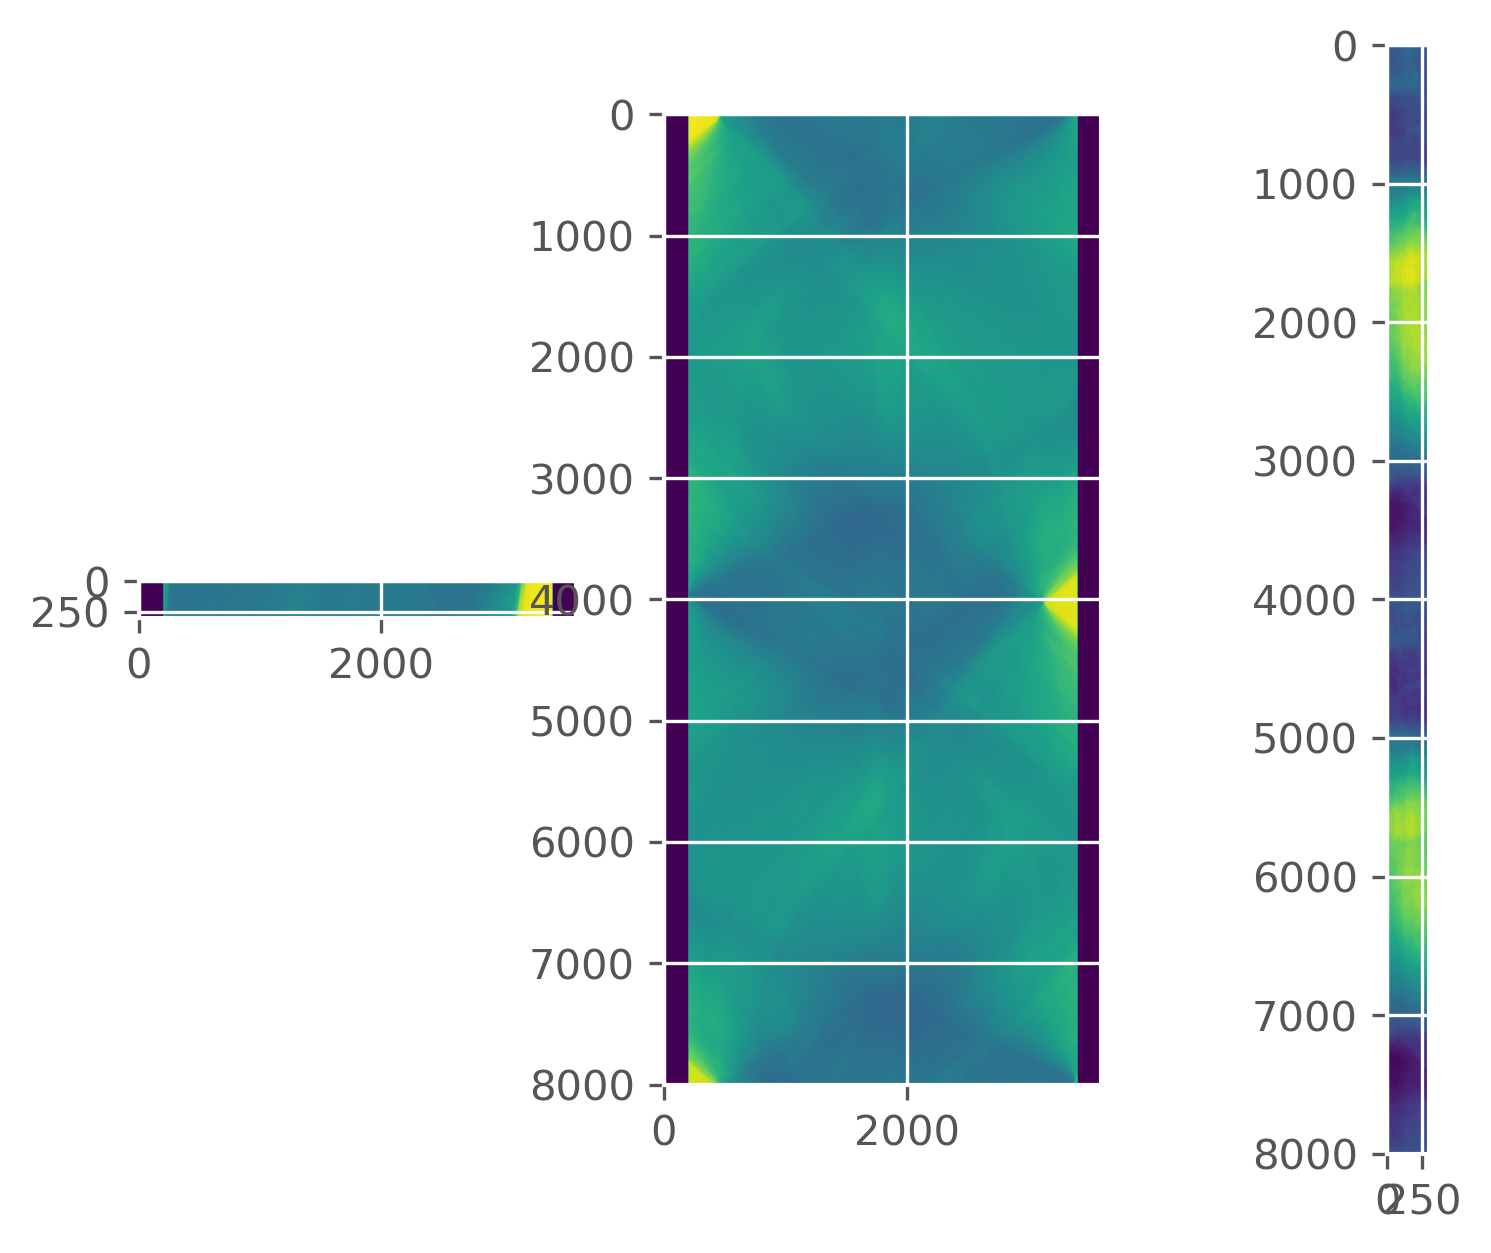

In [28]:
ru.plot_midplanes(projs_pad)

Update COR after padding

In [27]:
COR = projs_pad.shape[2]/2

In [ ]:
# del projs, projs_180
del recon

### Reconstruct and inspect one slice

In [33]:
recon_slice = round(projs.shape[1]/2)
# recon_slice = 400

|  |  |
| :--- | :--- |
| **Algorithm**      | `gridrec` |

In [157]:
recon = tomopy.recon(projs[:, [recon_slice], :],
                     theta,
                     center=COR+pad_size,
                     algorithm='gridrec',
                     sinogram_order=False
                    )

INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


In [ ]:
plt.imshow(recon.squeeze(), cmap='Greys')

|  |  |
| :--- | :--- |
| **Algorithm**      | `fbp CUDA ASTRA` |

In [35]:
options = {'proj_type': 'cuda', 'method': 'FBP_CUDA'}

In [37]:
recon = tomopy.recon(projs[:, [recon_slice], :],
                     theta,
                     center=COR,
                     algorithm=tomopy.astra,
                     options=options
                    )

INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


In [ ]:
plt.imshow(recon[recon_slice,:,:].squeeze(), cmap='Greys')

### CPU reconstruction of the entire dataset
|  |  |
| :--- | :--- |
| **Algorithm**      | `gridrec` |

In [298]:
recon = tomopy.recon(projs,
                     theta,
                     center=COR+pad_size,
                     algorithm='gridrec',
                     sinogram_order=False,
                     ncore=ncore)

INFO:tomopy.recon.algorithm:Reconstructing 36 slice groups with 36 master threads...


In [ ]:
ru.plot_midplanes(recon)

### GPU reconstruction with the ASTRA toolbox
|  |  |
| :--- | :--- |
| **Algorithm**      | `fbp CUDA ASTRA` |

In [26]:
extra_options = {'FilterType': 'hamming'}

In [ ]:
options = {'proj_type': 'cuda', 'method': 'FBP_CUDA', 'extra_options': extra_options}

In [ ]:
recon = tomopy.recon(projs_phase,
                     theta,
                     center=COR,
                     algorithm=tomopy.astra,
                     options=options,
                     ncore=10
                    )

In [37]:
extra_options = {'MinConstraint': 0}
options = {
    'proj_type': 'cuda',
    'method': 'SIRT_CUDA',
    'num_iter': 100,
    'extra_options': extra_options
}

In [15]:
import napari

In [31]:
viewer = napari.view_image(recon)

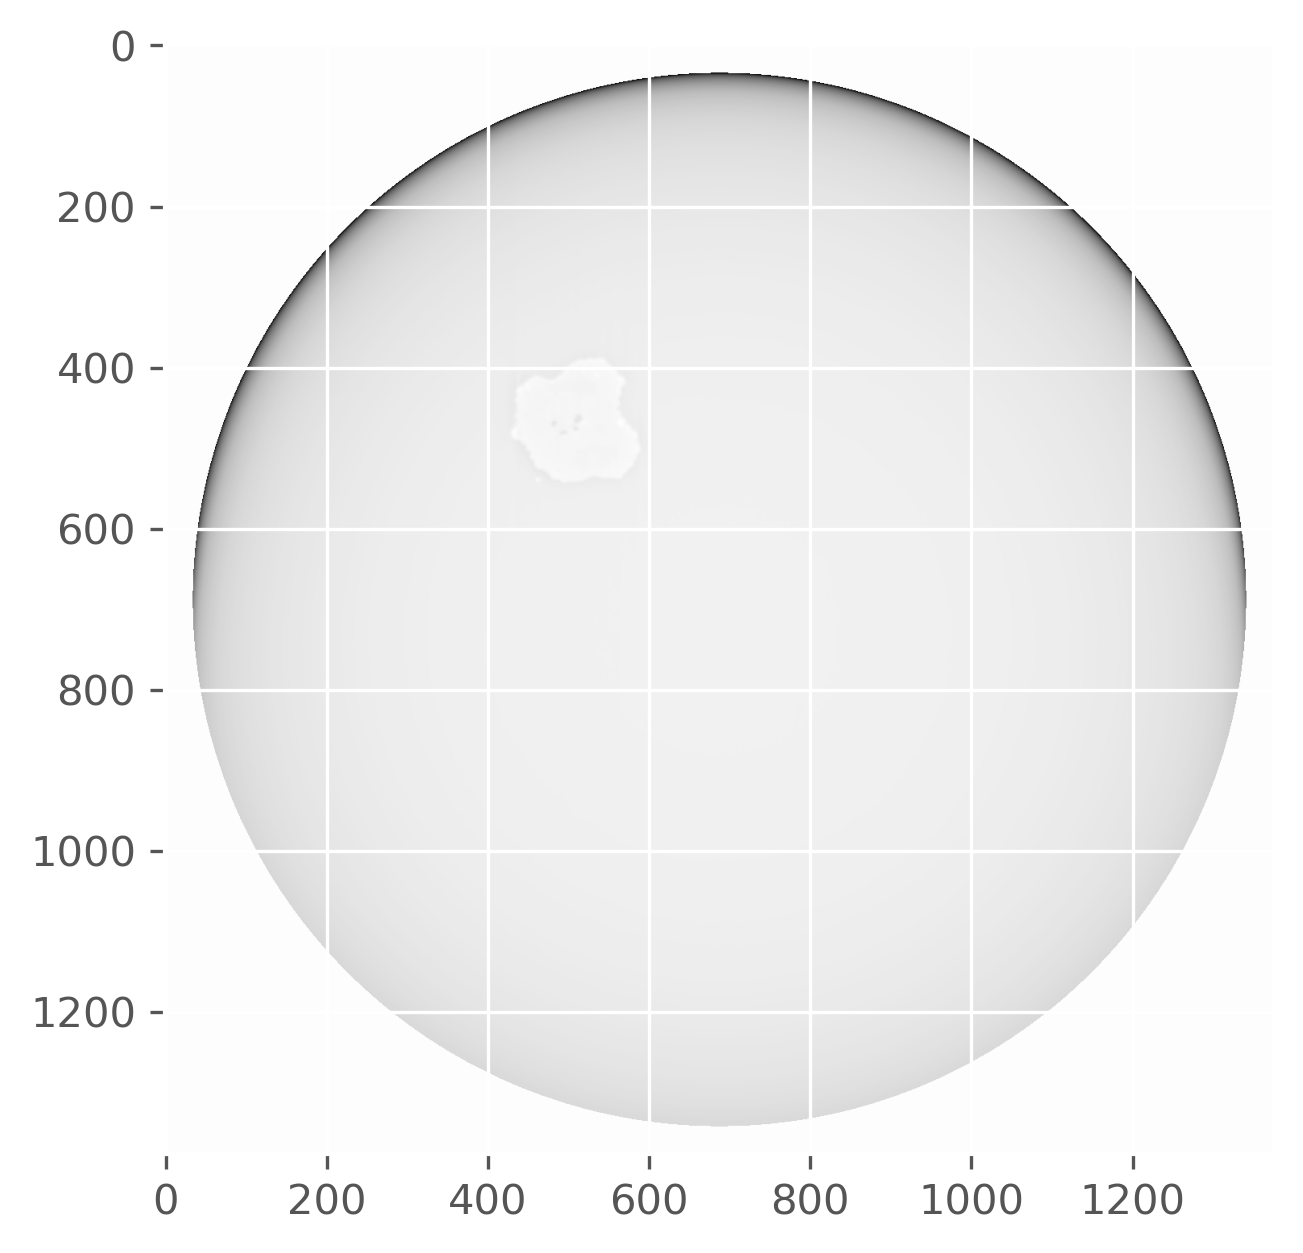

In [34]:
plt.imshow(recon[recon_slice,:,:].squeeze(), cmap='Greys')

## Post-processing
### Apply circular mask

In [30]:
recon = tomopy.circ_mask(recon,
                         axis=0,
                         ratio=0.95,
                         ncore=ncore)

In [ ]:
ru.plot_midplanes(recon)

### Ring artefact correction
Removes ring artefacts in the reconstruction domain

`tomopy.misc.corr.remove_ring(rec, center_x=None, center_y=None, thresh=300.0, thresh_max=300.0, thresh_min=-100.0, theta_min=30, rwidth=30, int_mode='WRAP', ncore=None, nchunk=None, out=None)`


In [34]:
recon = tomopy.misc.corr.remove_ring(recon)

In [32]:
recon = tomopy.misc.corr.remove_ring(recon,
                                     center_x=None,
                                     center_y=None,
                                     thresh=300.0,
                                     thresh_max=300.0,
                                     thresh_min=-100.0,
                                     theta_min=30,
                                     rwidth=30,
                                     int_mode='WRAP')

In [ ]:
plt.imshow(recon[:, 300, :], cmap='gray')
plt.show()

#### Apply again circular mask

In [79]:
recon = tomopy.circ_mask(recon, axis=0, ratio=0.95, val=-0.006)

### Scale to 0-255 (`uint8`)
The uint8 GV range for output slices can cover the full float32 range or be selected based on the 3D data histogram

In [77]:
subset_step = 20

In [78]:
recon_subset = recon[0::subset_step, 0::subset_step, 0::subset_step]

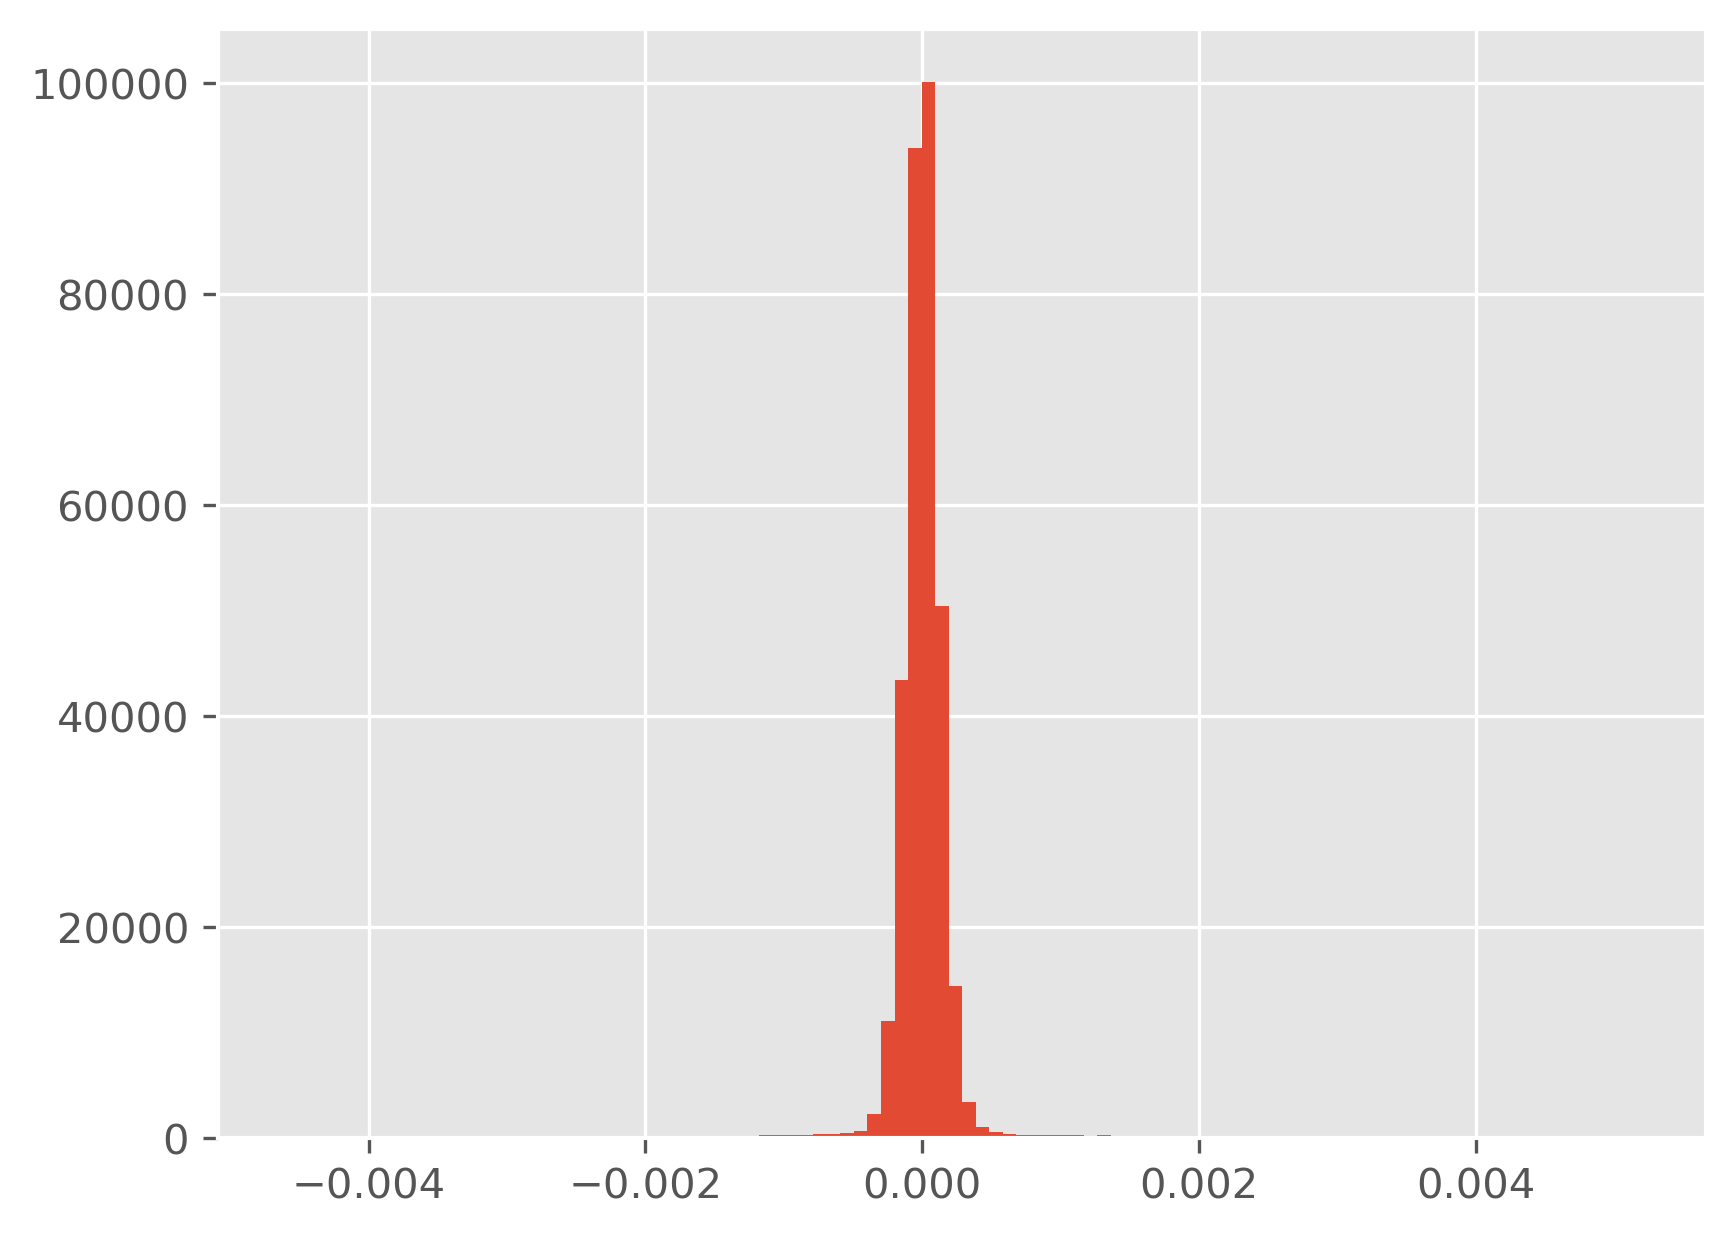

In [79]:
plt.hist(recon_subset.ravel(), bins=100)
plt.show()

In [ ]:
# uint8 GV range from data histogram (0.01 and 0.99 quantiles)
[range_min, q_95] = np.quantile(recon_subset.ravel(), [0.01, 0.99])
range_max = q_95 - range_min
print(range_min, range_max)

-7.854273877455853e-05 0.00048216310227871894


In [ ]:
# uint8 GV range as MIN and MAX of 3D data
range_min = np.nanmin(recon)
range_max = np.nanmax(recon)
range_max = range_max - range_min

In [42]:
range_min = -0.002
range_max = 0.002

In [ ]:
recon_uint8[recon_uint8 < 0] = 0

In [ ]:
recon_uint8[recon_uint8 > 255] = 255

In [96]:
# apply again circ mask
recon_uint8 = tomopy.circ_mask(recon_uint8, axis=0, ratio=0.95)

In [44]:
recon_uint8 = ru.touint(recon, 'uint8', [range_min, range_max])

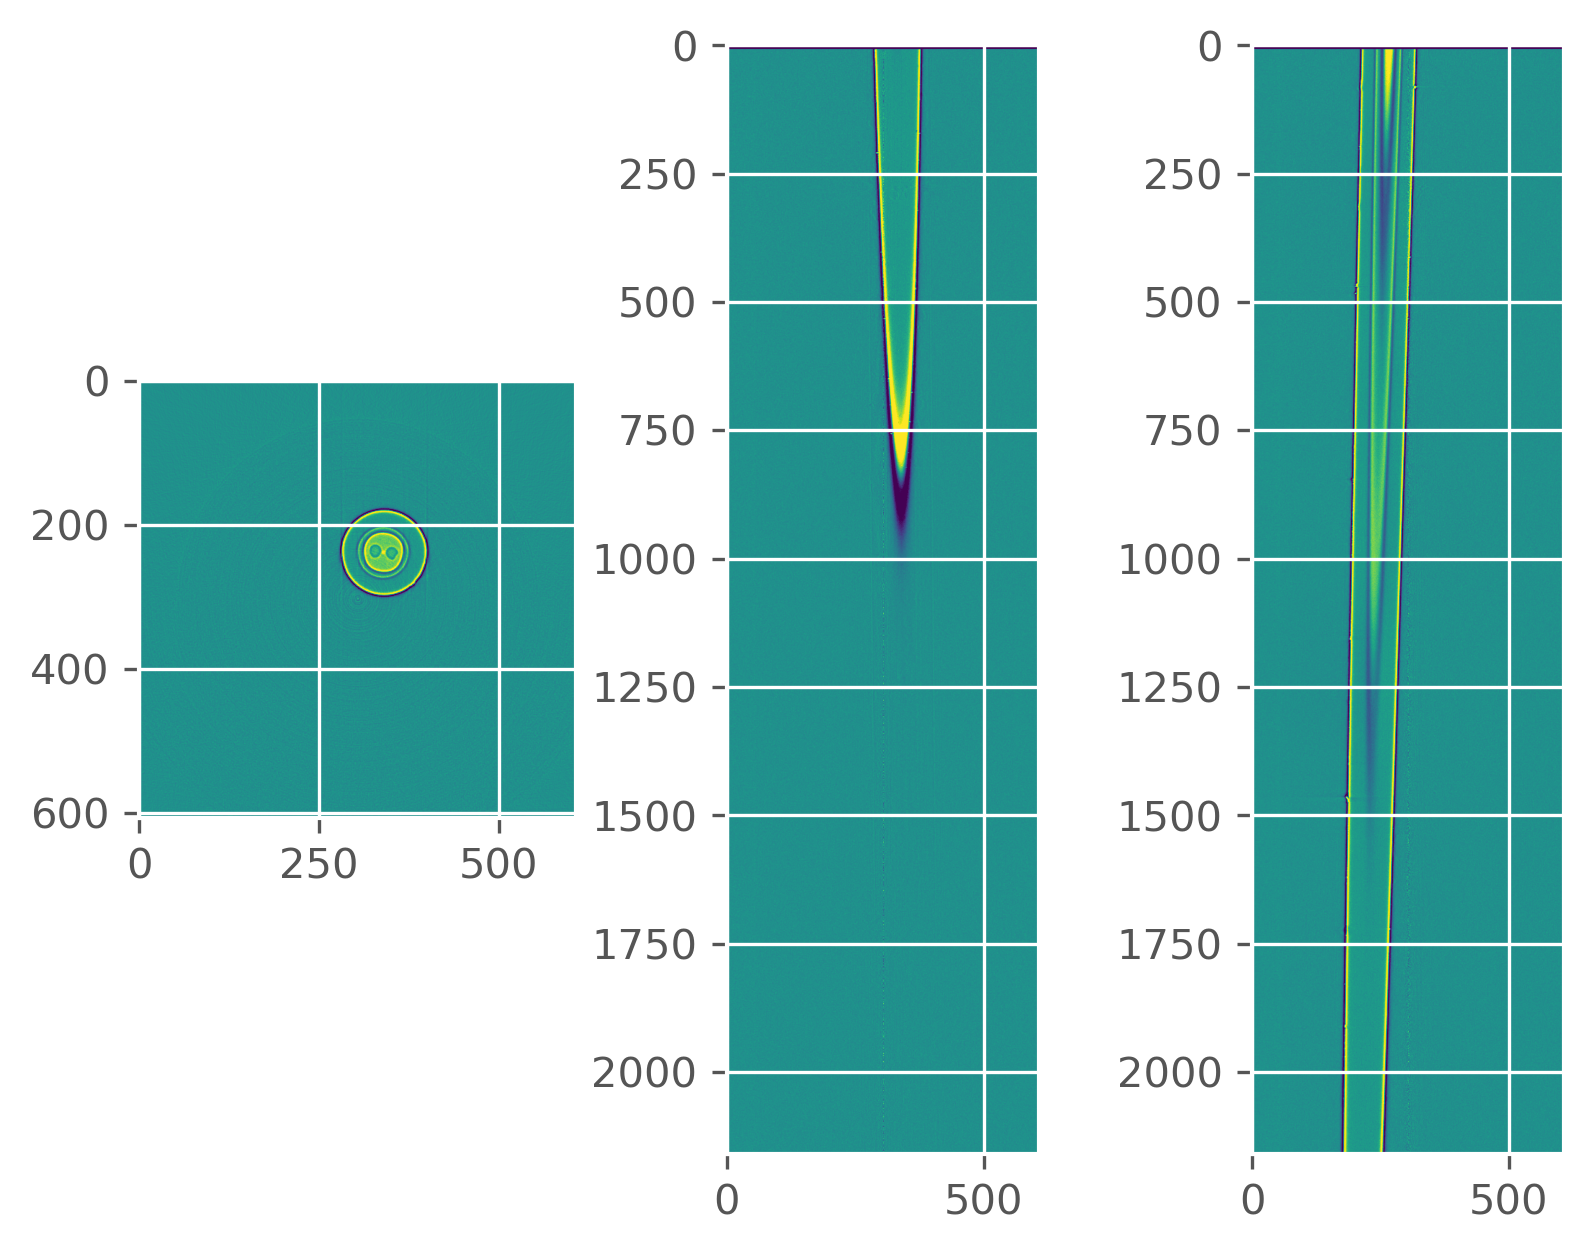

In [45]:
ru.plot_midplanes(recon_uint8)

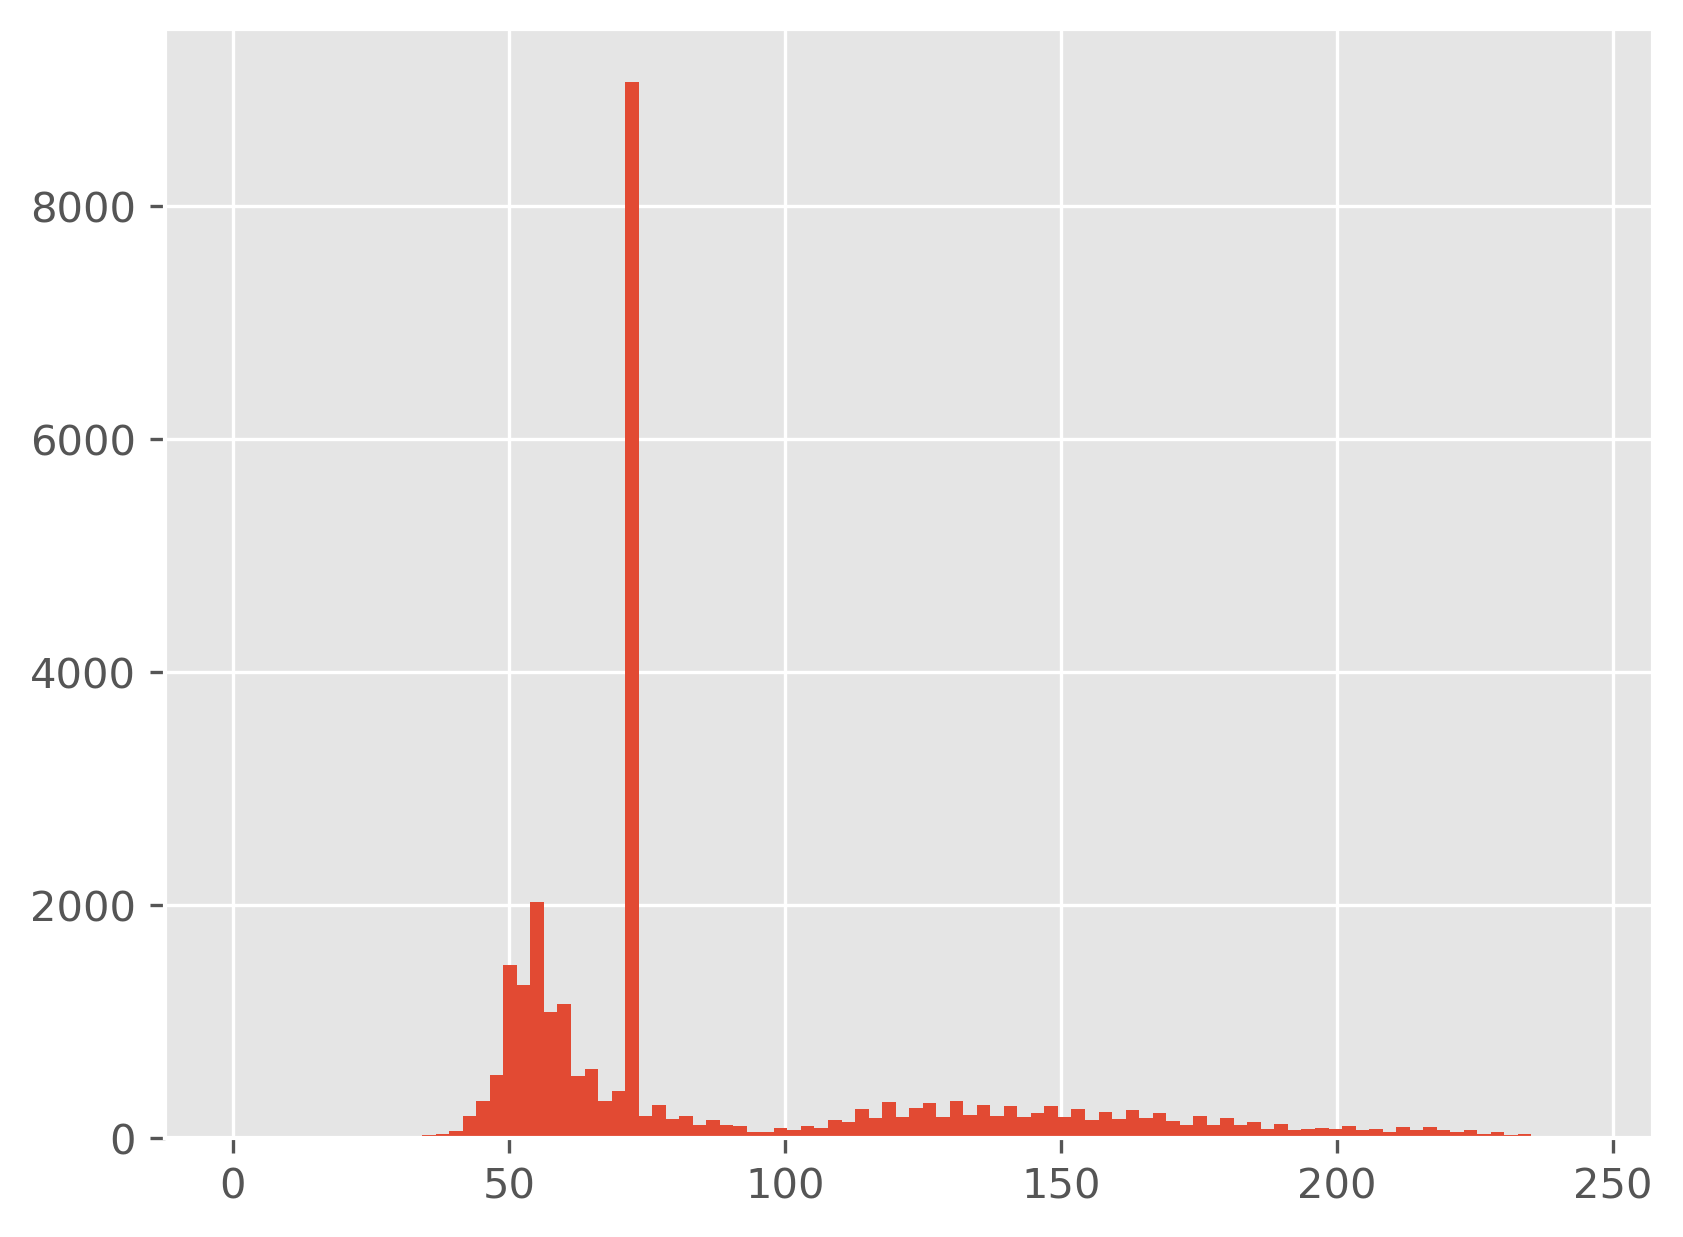

In [88]:
plt.hist(recon_uint8[0::100, 0::100, 0::100].round().ravel(), bins=100)
plt.show()

## Write recon dataset
### Write output tiff stack as `uint8`

In [46]:
# fileout = recon_dir_8bit+'slice.tiff'
fileout = recon_dir+'slice.tiff'
# fileout = '/home/beats/Data/tmp/slice.tiff'
dxchange.writer.write_tiff_stack(recon_uint8,
                                 fname=fileout,
                                 dtype='uint8',
                                 axis=0,
                                 digit=4,
                                 start=0,
                                 overwrite=True)

### Write output tiff stack as `float32`

In [383]:
fileout = recon_dir+'slice.tiff'
dxchange.writer.write_tiff_stack(recon, fname=fileout, axis=0, digit=4, start=0, overwrite=True)

#### Open virtual stack in ImageJ

In [75]:
os.system(Fiji_exe_stack + fileout + ' &')

0

OpenJDK 64-Bit Server VM warning: ignoring option PermSize=128m; support was removed in 8.0
OpenJDK 64-Bit Server VM warning: Using incremental CMS is deprecated and will likely be removed in a future release
